In [1]:
%matplotlib inline

import os
import numpy as np
from analysis.models.vr import RatCAVESession, VRSession
from analysis.adapters.openephys import load_events
from matplotlib.pyplot import figure

ModuleNotFoundError: No module named 'analysis'

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Place fields

In [155]:
source = '/home/andrey/storage2/andrey/data/processed'
animal = '00910'
session_id = '2019-07-24_10-59-13'

sessionpath = os.path.join(source, animal, session_id)

session = VRSession(sessionpath)
running_idxs = session.get_running_indexes()[0]

In [156]:
with open(os.path.join(sessionpath, "messages.events")) as f:
    raw = [x.split(' ') for x in f.readlines()]

for i, line in enumerate(raw):
    if "Processor:" in line:
        processor_line = i
        specs = line[-1].split('@')
        t_start = int(specs[0])
        frequency = int(specs[1].replace('Hz\x00\n', ''))

        break

events = np.array([(
           int(x[0]) - t_start,
           float(x[2]),
           np.float64(x[4]),
           np.float64(x[8].replace('\x00\n', ''))
       ) for x in raw[processor_line + 2:-2]])

session.events = events
session.frequency = frequency

In [157]:
sample_map = []  # position in sec, events in samples (like 30kHz)

for i, traj_event in enumerate(session.trajectory[:, 0]):
    nearest_event_idx = np.abs(session.events[:, 1] - traj_event).argmin()
    time_from_nearest = traj_event - session.events[nearest_event_idx][1]

    sample_map.append([session.events[nearest_event_idx][0]] + time_from_nearest * session.frequency)

session.trajectory = np.concatenate((session.trajectory, np.array(sample_map)), axis=1)

# Sync analysis

## Diffs of network events

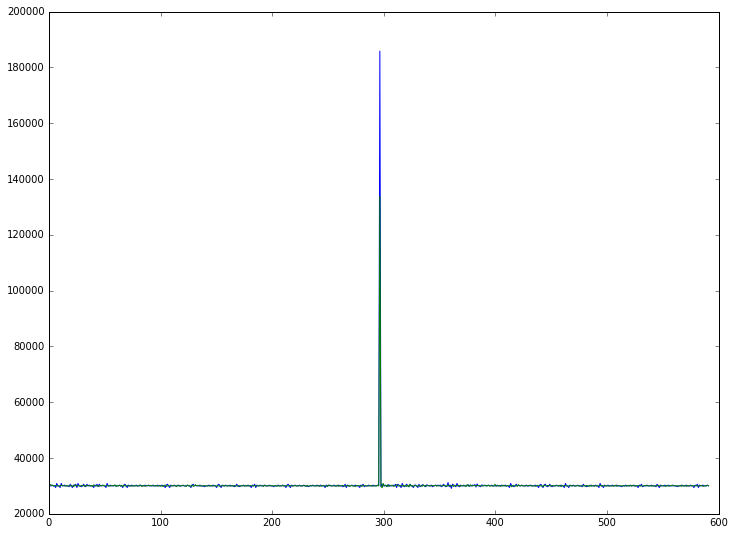

In [158]:
fig = figure(figsize=(12, 9))
ax = fig.add_subplot(1, 1, 1)

diffs = np.diff(session.events, axis=0)[:800]

points = len(diffs)
x_data = np.linspace(0, points, points)

ax.plot(x_data, diffs[:, 0])
ax.plot(x_data, (diffs[:, 1] - 1) * 2 * 10**4 + 30000)

## Trajectory to samples map

In [188]:
df = np.diff(session.trajectory[:,0])

(array([26724]),)

In [197]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.5f}'.format}, linewidth=130)

np.diff(session.trajectory[26723:26727, -1]), np.diff(session.trajectory[26723:26727, 0])

(array([       299.99971,     104329.99977,        299.99971]),
 array([         0.01000,          3.47067,          0.01000]))

In [232]:
orig = session.trajectory[26724]

inset = []
for x in range(345):
    row = list(orig)
    row[0] += (x + 1) * 0.01
    row[-1] += (x + 1) * 300
    
    inset.append(row)

traj = np.concatenate((
    session.trajectory[:26724],
    np.array(inset),
    session.trajectory[26725:]
), axis=0)

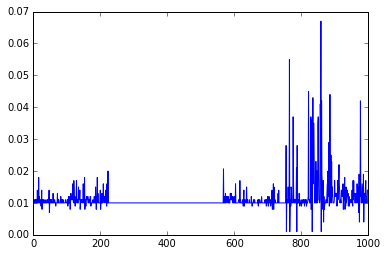

In [234]:
import matplotlib.pyplot as plt

#plt.plot(np.diff(session.trajectory[:26723,0]) * 30000 + 2000)
#plt.plot(np.diff(session.trajectory[:26723,-1]))

plt.plot(np.diff(traj[26500:27500,0]))

In [204]:
session.trajectory[26724][0] - session.trajectory[0][0]

299.3659999370575

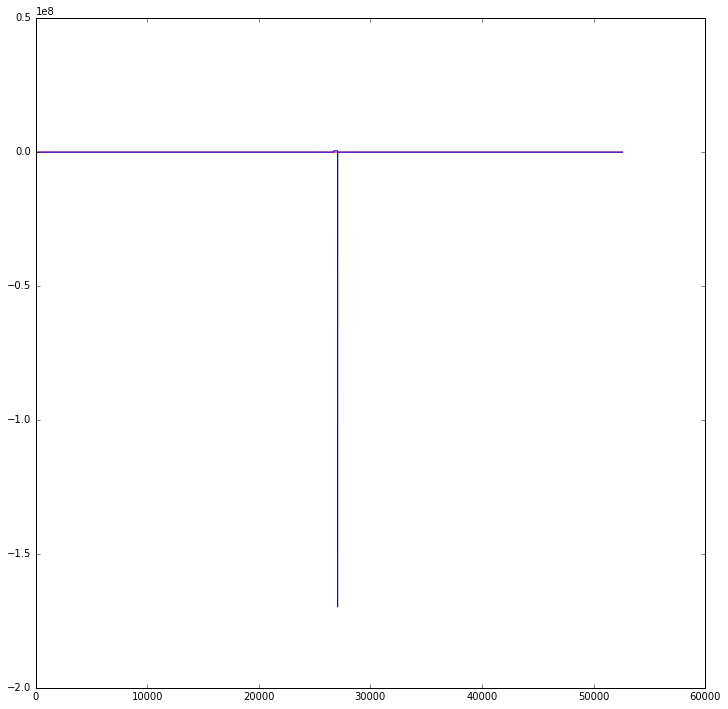

In [221]:
# sample_map = session.trajectory[:, -1]
# times_map = session.trajectory[:, 0]
sample_map = traj[:, -1]
times_map = traj[:, 0]

fig = figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)

sample_diffs = np.diff(sample_map)
time_diffs = np.diff(times_map)

#sample_diffs.min(), sample_diffs.max(), time_diffs.min(), time_diffs.max()

points = len(diffs)
x_data = np.linspace(0, points, points)

ax.plot(sample_diffs, color='r')
ax.plot((time_diffs * 5 * 10**4) - 2000, color='b')

In [127]:
#int(round((session.trajectory[-1][0] - session.trajectory[0][0]) * 50))
#session.trajectory[-1][0] - session.trajectory[0][0]
session.trajectory[100][-1]

39329.996395111084

In [128]:
frequency = 50

xy_positions = session.get_positions_at_freq(frequency)

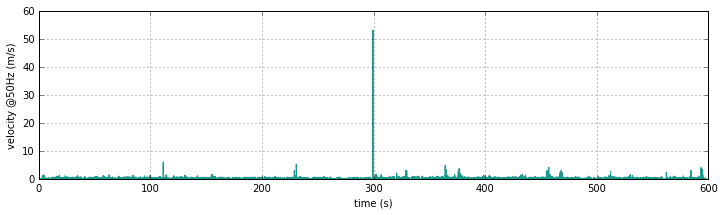

In [129]:
diffs = np.diff(xy_positions, axis=0)
dx = np.sqrt(np.square(diffs[:, 0]) + np.square(diffs[:, 1]))
dt = 1 / frequency
velocity = dx/dt

fig = figure(figsize=(12, 3))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('time (s)')
ax.set_ylabel('velocity @50Hz (m/s)')
ax.grid(True)

ax.plot(np.linspace(0, session.duration, len(velocity)), velocity, color='#1B998B')



Completed. 9 data is being fetched...
Processing unit group 6..

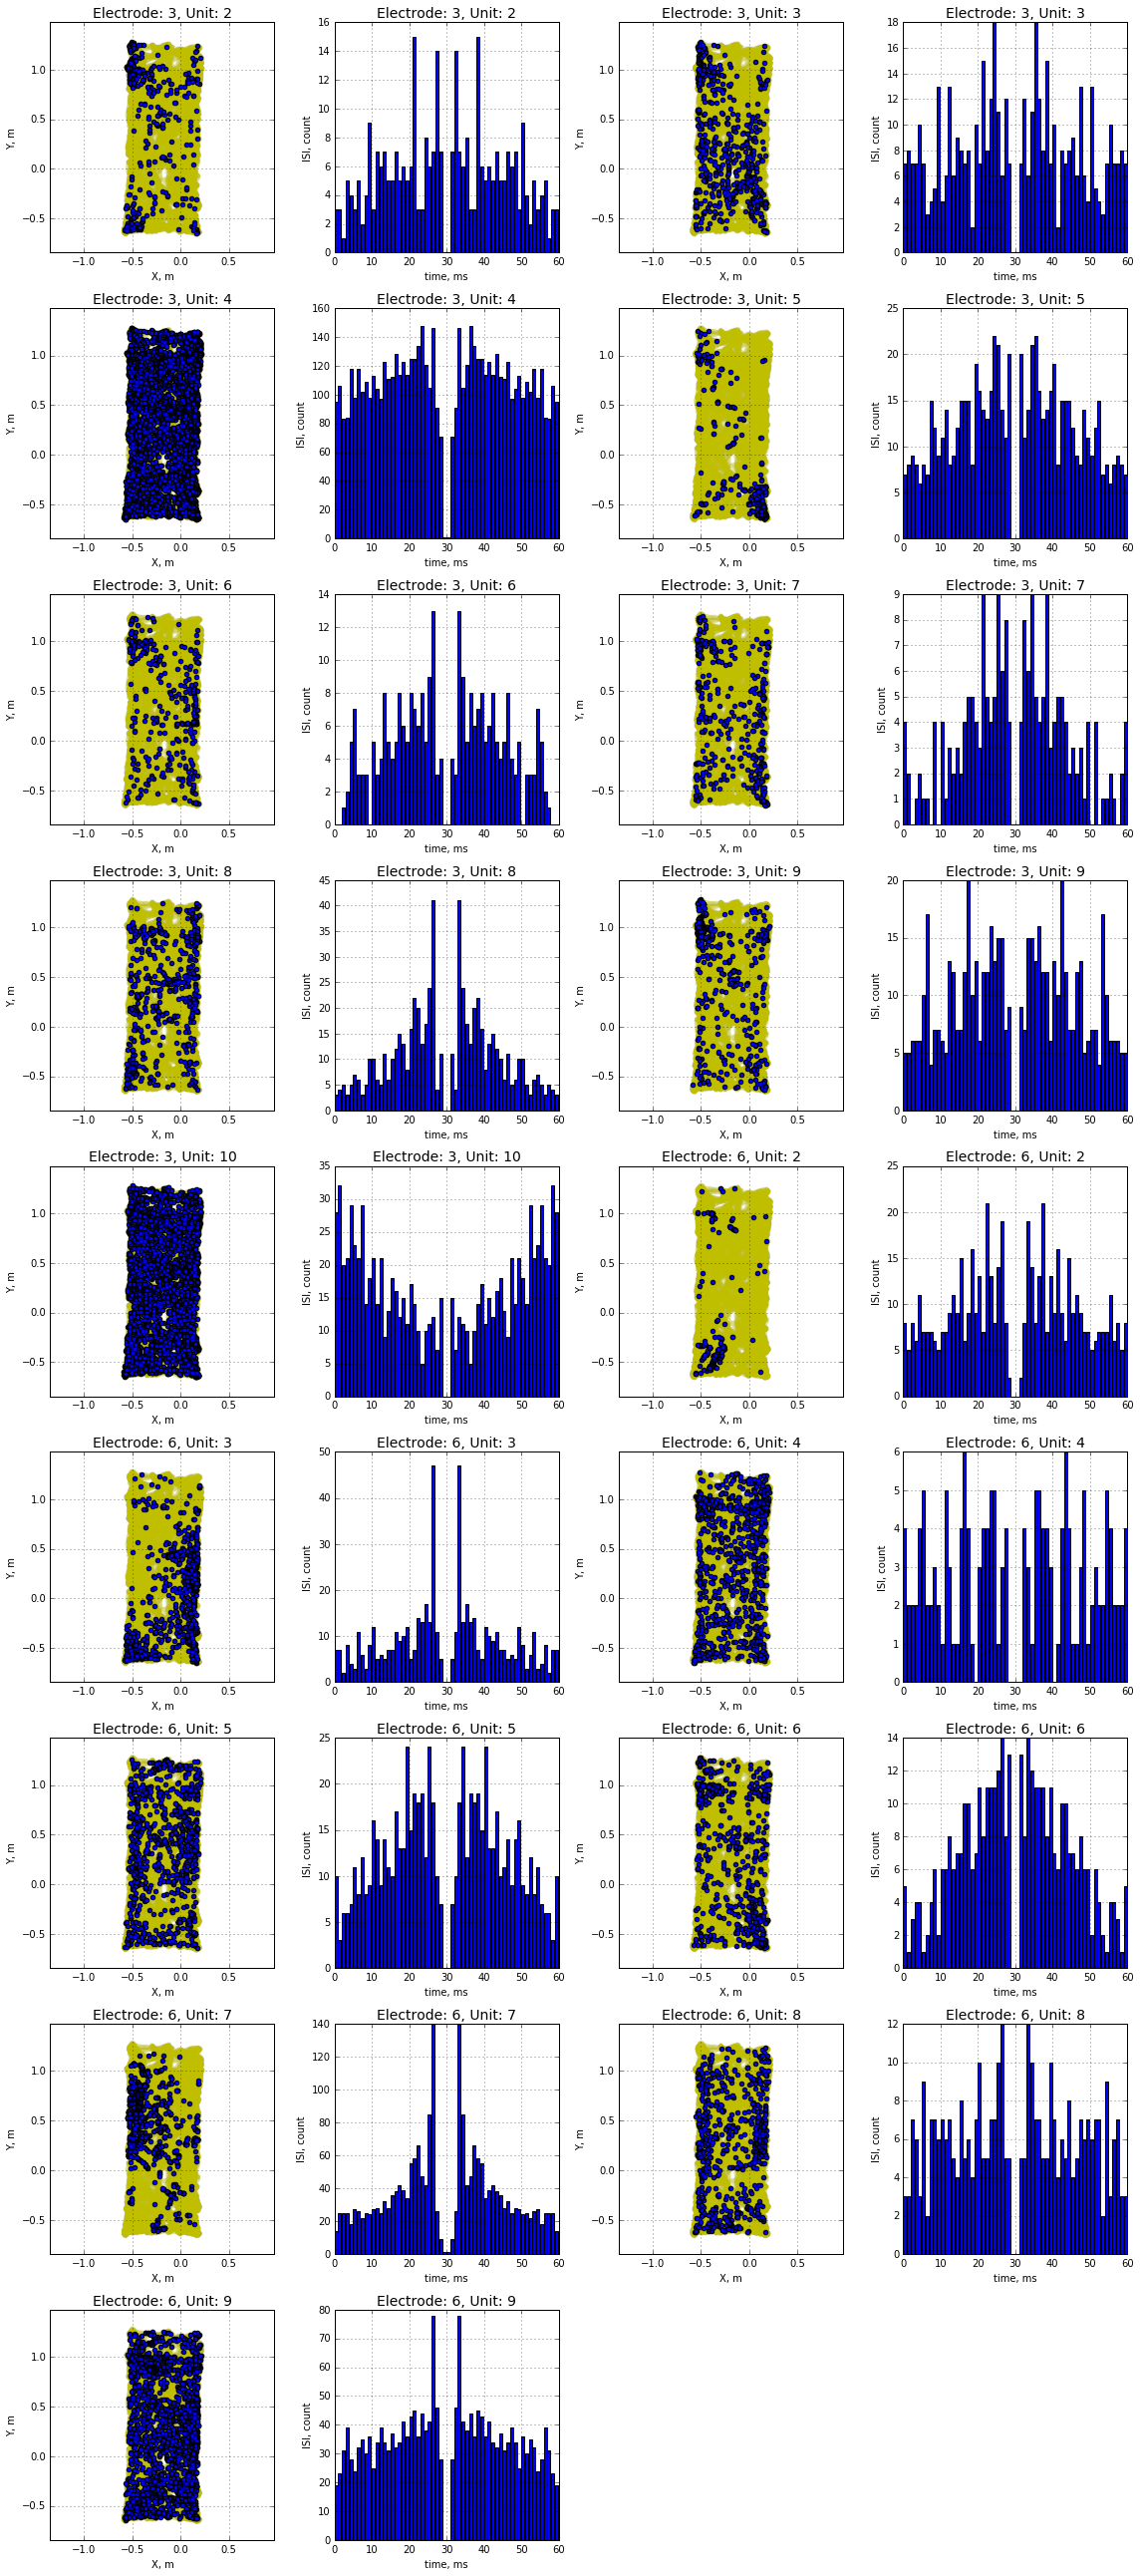

In [22]:
all_pos = session.trajectory[:, 1:3]
unit_pos_dict = session.get_unit_positions_with_autocorrs(running_idxs)

# building plots
fig = unit_place_firing_with_autocorr(all_pos, unit_pos_dict, per_row=4)

# saving to the disk
#fig.savefig(os.path.join(os.path.join(sessionpath, 'analysis'), 'unit_firing_maps_small.png'))

# Session sandbox

In [23]:
import numpy as np
from matplotlib.pyplot import figure

session.tetrode_unit_map

{1: [],
 2: [],
 3: [2, 3, 4, 5, 6, 7, 8, 9, 10],
 4: [],
 5: [],
 6: [2, 3, 4, 5, 6, 7, 8, 9],
 7: [],
 8: []}

# Distance over time

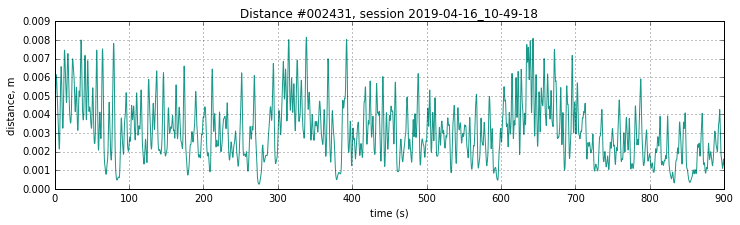

In [24]:
sm1 = session.distance_smoothed(ker_width=500)

fig = figure(figsize=(12, 3))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('time (s)')
ax.set_ylabel('distance, m')
ax.grid(True)

ax.plot(sm1[:,0] - sm1[0][0], sm1[:,1], color='#1B998B')
ax.set_title("Distance #%s, session %s" % (animal, session_id))

filename = "distance.png"
fig.savefig(os.path.join(source, animal, session_id, 'analysis', filename))

# Velocity over time

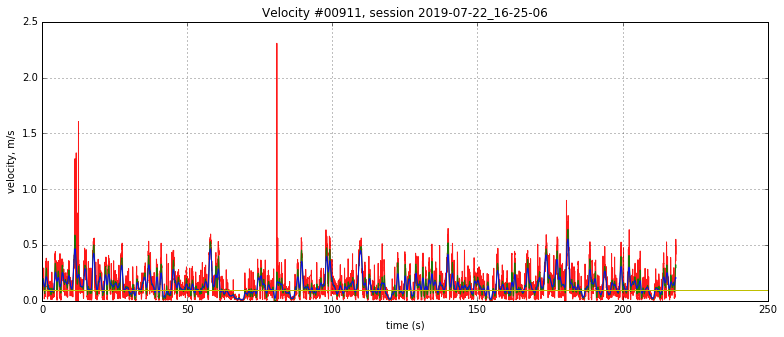

In [15]:
fig = figure(figsize=(13, 5))

ax = fig.add_subplot(111)
ax.set_xlabel('time (s)')
ax.set_ylabel('velocity, m/s')
ax.grid(True)

b_start = 7000
b_end = 28000

velocity1 = session.smoothed_velocity(ker_width=10)[b_start:b_end]
velocity2 = session.smoothed_velocity(ker_width=100)[b_start:b_end]
velocity3 = session.smoothed_velocity(ker_width=200)[b_start:b_end]

ax.plot(velocity1[:, 0] - velocity1[0][0], velocity1[:, 1], alpha=0.9, color='r')  # '#F46036'
ax.plot(velocity2[:, 0] - velocity2[0][0], velocity2[:, 1], alpha=0.9, color='g')
ax.plot(velocity3[:, 0] - velocity3[0][0], velocity3[:, 1], alpha=0.9, color='b')
ax.axhline(0.1, color='y')

ax.set_title("Velocity #%s, session %s" % (animal, session_id))

#filename = "velocity.png"
#fig.savefig(os.path.join(source, animal, session_id, 'analysis', filename))

# Place field

In [29]:
from analysis.models.analytics import place_field_2D

ttd = 6
unit = 7
sampling_rate = 50

spiket = session.get_unit_firing_at_freq(ttd, unit, sampling_rate)
pos = session.get_positions_at_freq(sampling_rate)

SyntaxError: invalid syntax (analytics.py, line 47)

In [27]:
occupancy_map, spiking_map, firing_map, s_firing_map = place_field_2D(pos, spiket, 50, 0.03, 0.1)

NameError: name 'place_field_2D' is not defined

NameError: name 'pos' is not defined

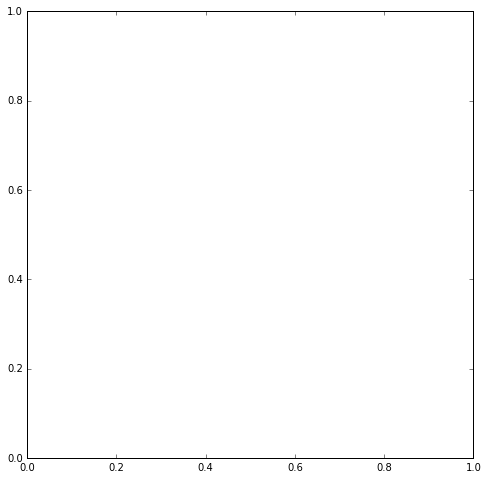

In [28]:
from analysis.plots.placecells import draw_place_field, get_figure_size
from matplotlib.pyplot import figure


fig = figure(figsize=(8, 8))
ax = fig.add_subplot(111)

x1, x2, y1, y2 = get_figure_size(pos)
limits = (x1, x2, y1, y2)
extent = [pos[:,0].min(), pos[:,0].max(), pos[:,1].min(), pos[:,1].max()]

draw_place_field(ax, s_firing_map, limits, extent)

title = "#%s, Electrode: %s, Unit: %s, Max: %2.1f Hz" % (animal, ttd, unit, s_firing_map.max())
ax.set_title(title, fontsize=14)


# Speed cells

## bulk for a session

In [9]:
sessions = ['/home/andrey/storage2/andrey/data/processed/002430/2019-02-12_16-43-05',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-13_17-49-29',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-14_11-29-08',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-14_16-34-47',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-15_15-46-05',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-15_21-12-17',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-16_09-39-47',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-16_17-42-46',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-17_15-26-41',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-18_16-17-26',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-19_16-21-36',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-21_22-49-21',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-21_22-52-14',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-22_13-50-30',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-22_15-41-56',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-25_13-06-55',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-26_10-12-17',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-26_15-50-46',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-26_19-54-47',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-27_13-21-54',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-27_22-50-06',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-02-28_11-21-03',
 '/home/andrey/storage2/andrey/data/processed/002430/2019-03-04_11-58-58']

In [34]:
from scipy import signal
from scipy.stats import linregress

import numpy as np


for sessionpath in sessions:
    session = RatCAVESession(sessionpath, alpha=4.3)

    velocity = session.smoothed_velocity(200)
    speedfile = os.path.join(sessionpath, 'analysis', 'speed.csv')

    with open(speedfile, 'w') as f:
        header = ', '.join(['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
        f.write('# ' + header + '\n')

        for ttd, units in session.tetrode_unit_map.items():
            for unit in units:
                firing = session.get_firing_smoothed(ttd, unit, 500)

                slope, intercept, r_value, p_value, std_err = linregress(velocity[:, 1], firing[:-1])

                data = [str(value) for value in [ttd, unit, slope, intercept, r_value, p_value, std_err]]
                f.write(', '.join(data) + '\n')

                print('\rProcessed group %s unit %s..' % (str(ttd), str(unit)), end="")

    print('Processed session %s' % sessionpath)

    #firing_norm = firing[:-1] / firing.max()
    #velocity_norm = velocity[:, 1] / velocity[:, 1].max()
    #results[ttd][unit] = np.corrcoef(velocity_norm, firing_norm)[0, 1]



Processed group 2 unit 2..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-12_16-43-05
Processed group 1 unit 2..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-13_17-49-29
Processed group 2 unit 4..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-14_11-29-08
Processed group 2 unit 5..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-14_16-34-47
Processed group 5 unit 2..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-15_15-46-05
Processed group 4 unit 3..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-15_21-12-17
Processed group 5 unit 4..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-16_09-39-47
Processed group 5 unit 2..Processed session /home/andrey/storage2/andrey/data/processed/002430/2019-02-16_17-42-46
Processed group 2 unit 2..Processed session /home/andrey/storage2/andrey/data/pr

In [14]:
import numpy as np
import os

results_sign = []
results_non_sign = []

for sessionpath in sessions:
    #sessionpath = '/home/andrey/storage2/andrey/data/processed/002430/2019-02-15_15-46-05'
    speedfile = os.path.join(sessionpath, 'analysis', 'speed.csv')

    if not os.path.exists(speedfile):
        continue

    unit_speed_data = np.loadtxt(speedfile, delimiter=',')
    if unit_speed_data.any():
        if not len(unit_speed_data.shape) > 1:
            unit_speed_data = unit_speed_data.reshape(1, unit_speed_data.shape[0])
        
        signific = []
        non_sign = []
        for unit_row in unit_speed_data:
            if unit_row[5] > 0.05:
                non_sign.append(unit_row[4])
            else:
                signific.append(unit_row[4])
                
        results_sign.append(signific)
        results_non_sign.append(non_sign)
    
len(results)

/usr/local/lib/python3.5/dist-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "/home/andrey/storage2/andrey/data/processed/002430/2019-02-22_15-41-56/analysis/speed.csv"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


22

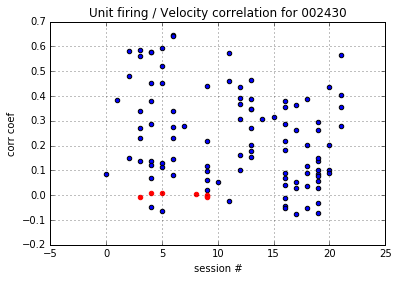

In [24]:
from matplotlib.pyplot import figure

new_res_s = []
new_res_n = []

for i, sess in enumerate(results_sign):
    new_res_s += [(i, value) for value in sess]

for i, sess in enumerate(results_non_sign):
    new_res_n += [(i, value) for value in sess]
    
nr1 = np.array(new_res_s)
nr2 = np.array(new_res_n)
    
fig = figure(figsize=(6, 4))

ax = fig.add_subplot(111)
ax.set_xlabel('session #')
ax.set_ylabel('corr coef')
ax.grid(True)

ax.scatter(nr1[:, 0], nr1[:, 1])
ax.scatter(nr2[:, 0], nr2[:, 1], color='r')

ax.set_title("Unit firing / Velocity correlation for %s" % "002430")

filename = "unit_velocity_corr.png"
fig.savefig(os.path.join(source, animal, filename))

## for a single unit with plot

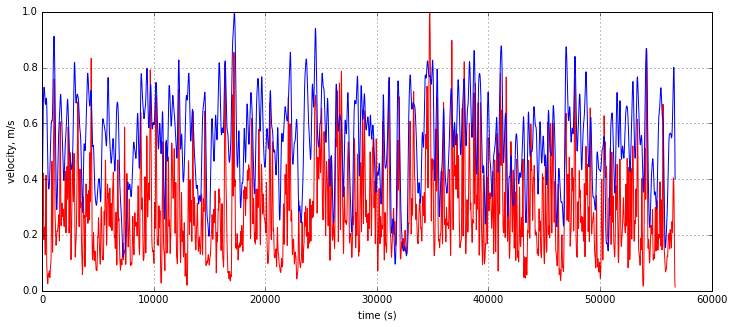

In [15]:
from matplotlib.pyplot import figure

ttd = 2
unit = 4

velocity = session.smoothed_velocity(200)
firing = session.get_firing_smoothed(ttd, unit, 500)

firing_norm = firing[:-1] / firing.max()
velocity_norm = velocity[:, 1] / velocity[:, 1].max()
        
fig = figure(figsize=(12, 5))

ax = fig.add_subplot(111)
ax.set_xlabel('time (s)')
ax.set_ylabel('velocity, m/s')
ax.grid(True)

ax.plot(velocity_norm, color='r')
ax.plot(firing_norm,   color='b')


# Head direction correlations

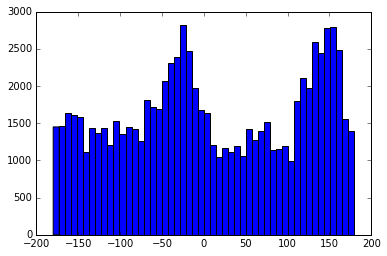

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plot = plt.hist(session.trajectory[:, 5], bins=50)

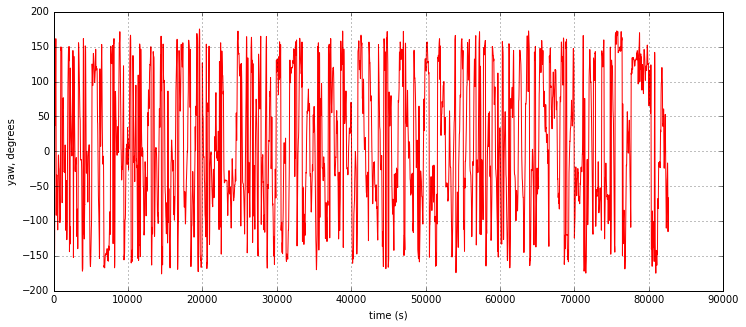

In [32]:
from scipy import signal
from matplotlib.pyplot import figure

ttd = 6
unit = 7

firing = session.get_firing_smoothed(ttd, unit, 500)

ker_width = 100
kernel = signal.gaussian(ker_width + 1, std=(ker_width + 1) / 7.2)
cvd = np.convolve(session.trajectory[:, 5], kernel, 'same') / kernel.sum()

#firing_norm = firing[:-1] / firing.max()

        
fig = figure(figsize=(12, 5))

ax = fig.add_subplot(111)
ax.set_xlabel('time (s)')
ax.set_ylabel('yaw, degrees')
ax.grid(True)

ax.plot(cvd, color='r')

In [37]:
from scipy.stats import linregress


linregress(cvd, firing)

LinregressResult(slope=-0.0018958993479845914, intercept=1.8856618804923559, rvalue=-0.038974843406511209, pvalue=3.7920756443379385e-29, stderr=0.00016911489209101707)

### make a dummy trajectory file

In [ ]:
with open(os.path.join(sessionpath, 'arena.traj')) as f:
    lines = f.readlines()

data = []
for line in lines[1:]:
    data.append([float(x) for x in line.split(' ')])

data = np.array(data)
with open(os.path.join(sessionpath, 'arena1.traj'), 'w') as f:
    for line in data:
        data1 = np.array(line)
        data1[0] -= 16160.931999921799
        f.write(' '.join([str(x) for x in data1]) + '\n')

# Merging sync event files

In [3]:
def merge_dat_files(source_dat_A, source_dat_B, destination_dat, channels=64, dt=np.int16):
    dat_A = np.fromfile(source_dat_A, dt)
    dat_B = np.fromfile(source_dat_B, dt)

    dat_A_r = dat_A.reshape(channels, len(dat_A) / channels)
    dat_B_r = dat_B.reshape(channels, len(dat_B) / channels)

    res = np.concatenate((dat_A_r, dat_B_r), axis=1)
    res.tofile(destination_dat)

In [4]:
def merge_event_files(source_event_A, source_event_B, destination_path, shift_in_samples):
    processor_line = 0

    with open(source_event_B) as f_B:
        lines_B = f_B.readlines()

    with open(source_event_A) as f_A:
        lines_A = f_A.readlines()

    for i, line in enumerate(lines_B):
        if "Processor:" in line.split(' '):
            processor_line = i
            break
    else:
        raise ValueError("Processor specs (frequency etc.) not found")

    shift_in_time = shift_in_samples / 30000
    
    with open(destination_path, 'w') as f:

        # first write entire A file to destination
        for line in lines_A:
            f.write(line)

        # then write only events from B file, shifted by sample_diff
        for line in lines_B[processor_line + 2:]:
            data = line.split(' ')
            d1 = int(data[0]) - shift_in_samples
            d2 = float(data[2]) - shift_in_time
            data[0] = "%s" % d1    # shift by a diff number of samples
            data[2] = "%.6f" % d2  # shift by a time diff

            f.write(' '.join(data))

In [5]:
def merge_traj_files(file_A, file_B, destination_path, time_shift_in_sec):
    with open(destination_path, 'w') as f:

        with open(file_A) as f_a:
            lines_A = [x for x in f_a.readlines() if not x.startswith('#')]

        with open(file_B) as f_b:
            lines_B = [x for x in f_b.readlines() if not x.startswith('#')]

        if not lines_A:  # file_A is empty
            for line in lines_B:
                f.write(line)

        elif not lines_B:  # file_B is empty
            for line in lines_A:
                f.write(line)

        else:
            # first write entire A file to destination
            for line in lines_A:
                f.write(line)

            # then write only points from B file, shifted by sample_diff
            for line in lines_B:
                data = line.split(' ')
                data[0] = str(float(data[0]) - time_shift_in_sec)  # shift by a diff number of samples

                f.write(' '.join(data))

In [1]:
def get_sessions_diff_in_samples(source_dat_A, source_event_A, source_event_B, channels=64, dt_size=2):
    # number of samples in the source_dat_A file
    samples_A = os.path.getsize(source_dat_A) / channels / dt_size

    with open(source_event_A) as f_A:
        lines_A = f_A.readlines()
        first_sample_A = int(lines_A[0].split(' ')[0])

    with open(source_event_B) as f_B:
        lines_B = f_B.readlines()
        first_sample_B = int(lines_B[0].split(' ')[0])

    return first_sample_B - (first_sample_A + samples_A)

In [5]:
source = '/home/andrey/storage2/andrey/data/processed'
animal = '00910'
session_id = "2019-07-24_10-59-13"


sampling_rate = 30000
sessionpath = os.path.join(source, animal, session_id)

In [6]:
source_dat_A = os.path.join(sessionpath, '2019-07-24_10-54-51', 'all.dat')
source_dat_B = os.path.join(sessionpath, '2019-07-24_11-03-35', 'all.dat')
destination_dat = os.path.join(sessionpath, 'all_n.dat')

source_event_A = os.path.join(sessionpath, '2019-07-24_10-54-51', 'messages.events')
source_event_B = os.path.join(sessionpath, '2019-07-24_11-03-35', 'messages.events')
destination_e_path = os.path.join(sessionpath, 'messages.events')

source_pos_A = os.path.join(sessionpath, '2019-07-24_10-54-51', 'positions.traj')
source_pos_B = os.path.join(sessionpath, '2019-07-24_11-03-35', 'positions.traj')
destination_p_path = os.path.join(sessionpath, 'positions.traj')

In [8]:
get_sessions_diff_in_samples(source_dat_A, source_event_A, source_event_B) / 30000

222.6824

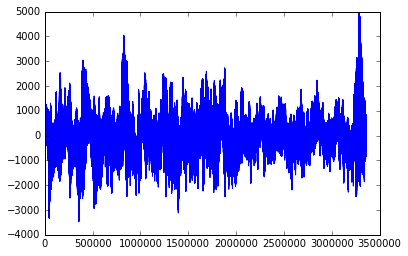

In [24]:
import matplotlib.pyplot as plt



plt.plot(dat_A_r[27][-3360000:])